# Automatic Classification for Diabetic Retinopathy
## BIOENGRINEERING C275 FINAL PROJECT

Dennis Shen (UID: 304755705)

"Diabetic retinopathy (DR) is a complication that can arise in people that have diabetes mellitus and can lead to a variety of sight related issues including but not limited to blurry vision, loss in color perception, poorer night vision, and even blindness in severe cases. DR arises when elevated blood sugar levels damage blood vessels in the retina. For those living with diabetes, proper eye exams and diagnosis of a potential onset of DR is critical to mitigating any severe complications, however, diagnosis of DR requires time, expertise, and money."  

A brief description of this notebook and how it was developed, as well as an analysis of the results are provided in the report for this project.

The following packages (with version numbers) were used in this project:
- sklearn (0.24.1)
- pandas (1.2.3)
- numpy (1.20.1)
- seaborn (0.11.1)
- matplotlib (3.3.4)
- scipy (1.6.1)

In order to run all of the different models and visualizations, the user will need the dataset from the UCI Machine Learning Repository and preferably Python 3.7.9 (64-bit), which is what this project was developed on. 


In [1]:
# Libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from scipy.io import arff

## Data Visualization

Perform initial data visualization to see if there is anything that can be used to separate the data easily from itself.

     0    1     2     3     4     5     6     7          8          9  \
0  1.0  1.0  22.0  22.0  22.0  19.0  18.0  14.0  49.895756  17.775994   
1  1.0  1.0  24.0  24.0  22.0  18.0  16.0  13.0  57.709936  23.799994   
2  1.0  1.0  62.0  60.0  59.0  54.0  47.0  33.0  55.831441  27.993933   
3  1.0  1.0  55.0  53.0  53.0  50.0  43.0  31.0  40.467228  18.445954   
4  1.0  1.0  44.0  44.0  44.0  41.0  39.0  27.0  18.026254   8.570709   

          10        11        12        13        14        15        16  \
0   5.270920  0.771761  0.018632  0.006864  0.003923  0.003923  0.486903   
1   3.325423  0.234185  0.003903  0.003903  0.003903  0.003903  0.520908   
2  12.687485  4.852282  1.393889  0.373252  0.041817  0.007744  0.530904   
3   9.118901  3.079428  0.840261  0.272434  0.007653  0.001531  0.483284   
4   0.410381  0.000000  0.000000  0.000000  0.000000  0.000000  0.475935   

         17   18 Class  
0  0.100025  1.0  b'0'  
1  0.144414  0.0  b'0'  
2  0.128548  0.0  b'1'  
3  0

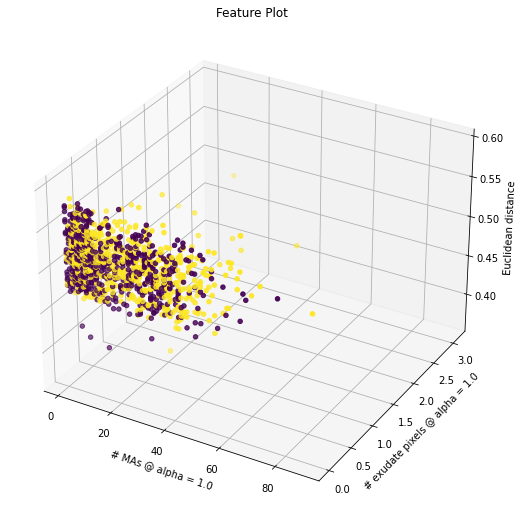

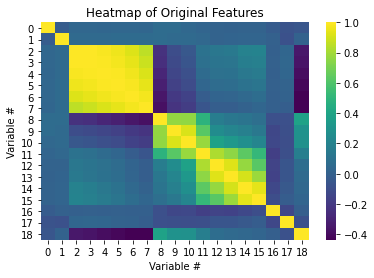

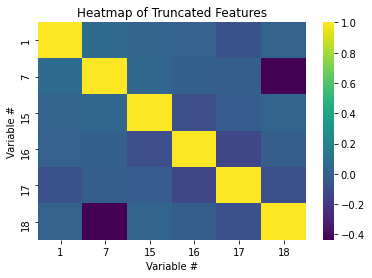

In [2]:
# Load in the dataset:
data = arff.loadarff('messidor_features.arff')
df = pd.DataFrame(data[0])
print(df.head())
rawData = df.to_numpy(dtype = 'float64')

# # Remove the first column (it makes no sense to include x0 because they are
# # all 1, good quality assessment).
rData = np.delete(rawData, [0, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 19], axis = 1)

# Extract the results:
rawResults = rawData[:, -1]

# Initial data visualization:
fig = plt.figure(figsize = (16,9))
ax = plt.axes(projection ="3d")
ax.scatter3D(rData[:, 1], rData[:, 2], rData[:,3], c = rawResults)
ax.set_xlabel('# MAs @ alpha = 1.0')
ax.set_ylabel('# exudate pixels @ alpha = 1.0')
ax.set_zlabel('Euclidean distance')
plt.title('Feature Plot')
plt.show()
    
correlation = df.corr()
sns.heatmap(correlation, cmap='viridis')
plt.xlabel('Variable #')
plt.ylabel('Variable #')
plt.title('Heatmap of Original Features')
plt.show()

# Cleaned data visualization:
newHeatmap = pd.DataFrame(rData)
correlation = newHeatmap.corr()
xticklabels = [ 1, 7, 15, 16, 17, 18]
yticklabels = xticklabels
sns.heatmap(correlation, xticklabels = xticklabels,
            yticklabels = yticklabels, cmap='viridis')
plt.xlabel('Variable #')
plt.ylabel('Variable #')
plt.title('Heatmap of Truncated Features')
plt.show()

## Logistic Regression

Develop a logistic regression model for classification with tuned hyperparameters.

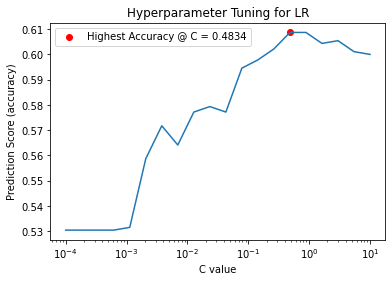

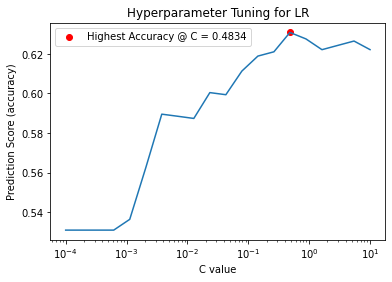

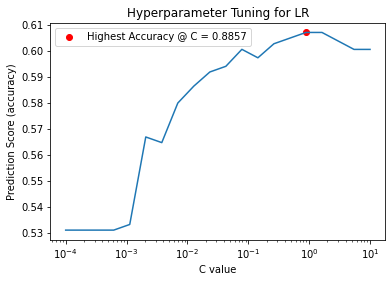

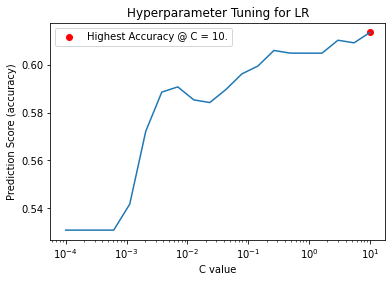

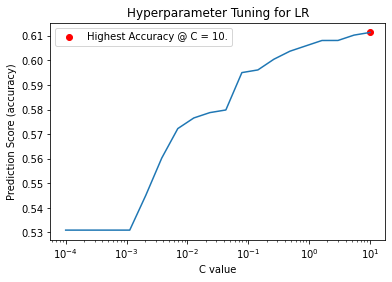

The average accuracy of the LR model across all folds is: 0.5951
The average optimal value for C across all folds is: 4.3705


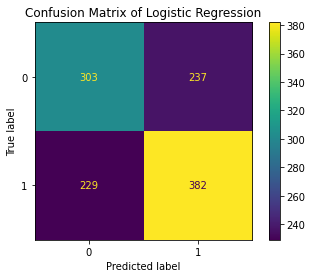

In [3]:
# Setup cross validation and tuning:
n_splits = 10
n_holdouts = 5
lrScores = []
scaler = StandardScaler()

# Set aside some data for evaluating tuned model performance:
# xTune, xTest, yTune, yTest = train_test_split(rData, rawResults)

# Rename variables:
rawX = rData
rawY = rawResults

# Initialize some empty lists for storing scores:
bestCvals = []
allScores = [] # allScores contains the score of the model with the best C (from CV) on the hold out set
cMatrices = [] # cMatrices stores the confusion matrices

# Nested cross validation loop for model tuning:
holdoutSet = StratifiedKFold(n_splits = n_holdouts, shuffle = True, random_state = 125)
for modelDataIdx, holdoutDataIdx in holdoutSet.split(rawX, rawY):
    lrScores = []

    # Hyperparameter tuning for logisitic regression:
    cVector = np.logspace(-4, 1, num = 20)
    # This data is for developing the model:
    modelX, modelY = rawX[modelDataIdx], rawY[modelDataIdx]
    # This data is for evaluating the hyperparameter tuned model:
    holdoutX, holdoutY = rawX[holdoutDataIdx], rawY[holdoutDataIdx]

    # Now loop through all Cs after splitting into model and holdout data:
    for cValue in cVector:
        cScore = []

        # Second k-fold CV loop:
        lrKFold = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 125156)
        for train_idx, test_idx in  lrKFold.split(modelX, modelY):
            # sklearn cannot converge without scaling data 
            # (gradient descent/convergence issues):
            trainingDataX, testDataX = scaler.fit_transform(modelX[train_idx]), scaler.fit_transform(modelX[test_idx])  
            trainingDataY, testDataY = modelY[train_idx], modelY[test_idx]

            # Logistic regression:
            lrModel = LogisticRegression(C = cValue, max_iter = 500, n_jobs = 3)
            lrModel.fit(trainingDataX, trainingDataY)
    
            # The accuracy_score function computes the accuracy, 
            # either the fraction (default) or the count (normalize=False) 
            # of correct predictions.
            cScore.append(lrModel.score(testDataX, testDataY))

        # Now, cScore contains 1x10 scores based on the 10 folds.
        # The end of the CV loop will give you a score at each fold:
        lrScores.append(cScore)

    # lrScores should be a 20x10 array, the rows contain the scores of each C value.
    # print(np.shape(lrScores))
    # Once you've gone through all the C-values, average the scores, find the best C-value:
    lrScores = np.asarray(lrScores)
    lrScores = np.average(lrScores, axis = 1)
    optimalC = np.argmax(lrScores)
    bestCvals.append(cVector[optimalC])
    opt = 'Highest Accuracy @ C = ' + str(np.format_float_positional(np.float16(cVector[optimalC])))   
    # print(opt) 

    # Now evaluate model on the holdout set with the optimal value for C:
    lrModel = LogisticRegression(C = cVector[optimalC], max_iter = 500)
    lrModel.fit(modelX, modelY)
    predictions = lrModel.predict(holdoutX)
    allScores.append(lrModel.score(holdoutX, holdoutY))
    


    # Plot score vs C value:
    plt.figure()
    plt.semilogx(cVector, lrScores)
    plt.scatter(cVector[optimalC], lrScores[optimalC], c = 'r', label = opt)
    plt.xlabel('C value')
    plt.ylabel('Prediction Score (accuracy)')
    plt.title('Hyperparameter Tuning for LR')
    plt.legend()
    plt.show()

    # Confusion matrix:
    cMatrices.append(confusion_matrix(holdoutY, predictions))

# Output of logisitic regression model:
print('The average accuracy of the LR model across all folds is:',
      "%.4f"%np.average(allScores))

# Output of logisitic regression model:
print('The average optimal value for C across all folds is:',
      "%.4f"%np.average(bestCvals))

# Confusion matrix:
cMatrices = np.asarray(cMatrices)
cResults = np.sum(cMatrices, axis = 0)
dispLR = ConfusionMatrixDisplay(cResults)
dispLR.plot()
plt.title('Confusion Matrix of Logistic Regression')
plt.show()

## Support Vector Machine Model

Develop a SVM model with tuned hyperparameters using gridSearchCV first for kernel and C value, then normal tuning for the best value for gamma.

In [4]:
# Recall large C is really close to hard-margin SVM.
# Hyperparameter tuning (C and kernel type).
  
# Using the gridSearchCV method from sklearn:
param_grid = {'kernel': ['rbf', 'poly'],
              'C': np.logspace(-3, 3, num = 6)}
    
optObject = GridSearchCV(svm.SVC(), param_grid, 
                         refit = True, scoring = 'accuracy', cv = 4, n_jobs = -1)
optObject.fit(rawX, rawY)
print('\nThe grid search returns:', optObject.best_params_)
    
optParam = optObject.best_params_['C']


The grid search returns: {'C': 1000.0, 'kernel': 'rbf'}


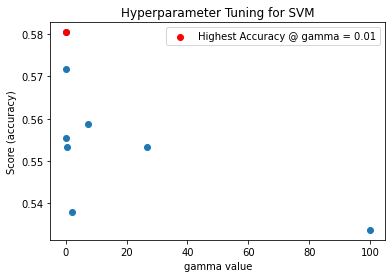

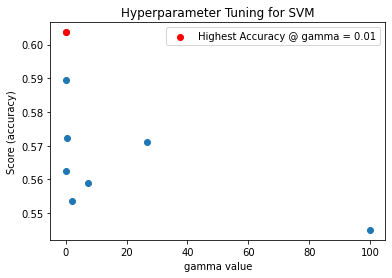

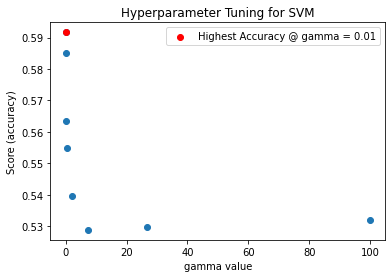

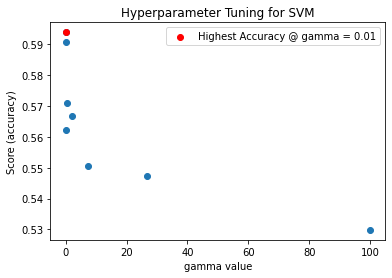

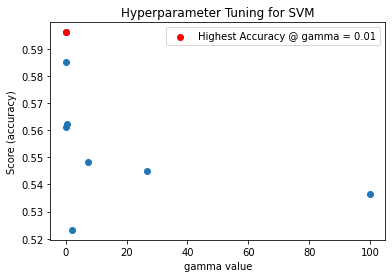

The average accuracy of the SVM model across all folds is: 0.6073
The average optimal value for gamma across all folds is: 0.0100


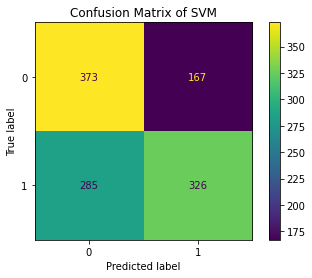

In [5]:
# With the grid search already done now try to tune gamma, since it is hard to tune in gridSearchCV:
bestGvals = []
allScores = []
svmMatrices = []
for modelDataIdx, holdoutDataIdx in holdoutSet.split(rawX, rawY):
    svmScores = []

    # Hyperparameter tuning for SVM:
    gammaVector = np.logspace(-2, 2, num = 8)
    # This data is for developing the model:
    modelX, modelY = rawX[modelDataIdx], rawY[modelDataIdx]
    # This data is for evaluating the hyperparameter tuned model:
    holdoutX, holdoutY = rawX[holdoutDataIdx], rawY[holdoutDataIdx]

    # Now loop through all Cs after splitting into model and holdout data:
    for gValue in gammaVector:
        gScore = []

        # Second k-fold CV loop:
        svmKFold = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 125156)
        for train_idx, test_idx in svmKFold.split(modelX, modelY):
            # sklearn cannot converge without scaling data 
            # (gradient descent/convergence issues):
            trainingDataX, testDataX = scaler.fit_transform(modelX[train_idx]), scaler.fit_transform(modelX[test_idx])  
            trainingDataY, testDataY = modelY[train_idx], modelY[test_idx]

            # Define the SVM model:
            clf = svm.SVC(kernel = 'rbf', C = optParam, gamma = gValue, cache_size = 1000)
            clf.fit(trainingDataX, trainingDataY)
            predictions = clf.predict(testDataX)
    
            # Save results for the confusion matrix:
            gScore.append(clf.score(testDataX, testDataY))

        # The end of the CV loop will give you a score at each fold:
        svmScores.append(gScore)

    # Once you've gone through all the gamma values, average the scores, find the best gamma value:
    svmScores = np.asarray(svmScores)
    svmScores = np.average(svmScores, axis = 1)
    optimalG = np.argmax(svmScores)
    bestGvals.append(gammaVector[optimalG])
    opt = 'Highest Accuracy @ gamma = ' + str(np.format_float_positional(gammaVector[optimalG]))    

    # Now evaluate model on the holdout set with the optimal value for gamma:
    clf = svm.SVC(kernel = 'rbf', C = optParam, gamma = gammaVector[optimalG], cache_size = 1000)
    clf.fit(modelX, modelY)
    predictions = clf.predict(holdoutX)
    allScores.append(clf.score(holdoutX, holdoutY))

    # Plot score vs gamma value:
    plt.figure()
    plt.scatter(gammaVector, svmScores)
    plt.scatter(gammaVector[optimalG], svmScores[optimalG], c = 'r', label = opt)
    plt.xlabel('gamma value')
    plt.ylabel('Score (accuracy)')
    plt.title('Hyperparameter Tuning for SVM')
    plt.legend()
    plt.show()

    # Confusion matrix:
    svmMatrices.append(confusion_matrix(holdoutY, predictions))

# Output of SVM model:
print('The average accuracy of the SVM model across all folds is:',
      "%.4f"%np.average(allScores))

# Output of SVM model:
print('The average optimal value for gamma across all folds is:',
      "%.4f"%np.average(bestGvals))

# Confusion matrix:
svmMatrices = np.asarray(svmMatrices)
svmResults = np.sum(svmMatrices, axis = 0)
dispSVM = ConfusionMatrixDisplay(svmResults)
dispSVM.plot()
plt.title('Confusion Matrix of SVM')
plt.show()

## K-Nearest Neighbors

Develop a KNN model with tuned hyperparameters for the number of neighbors to use.

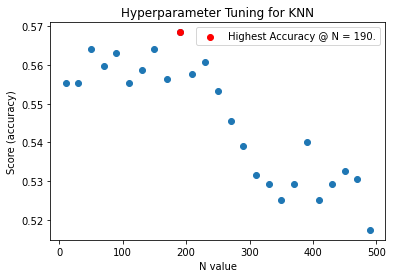

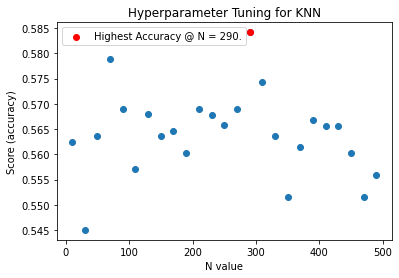

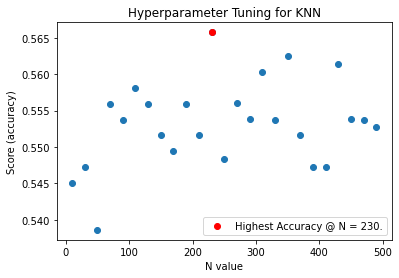

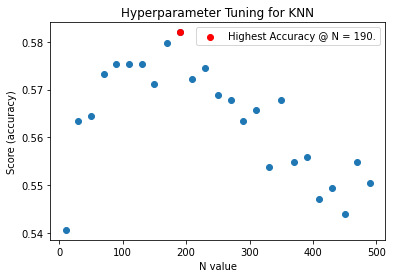

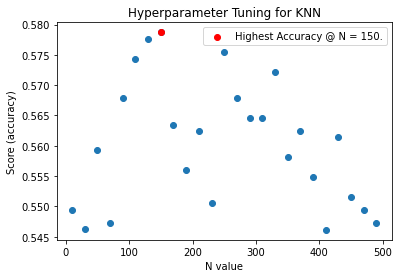

The average accuracy of the knn model across all folds is: 0.5743
The average optimal value for n_neighbors across all folds is: 210.0000


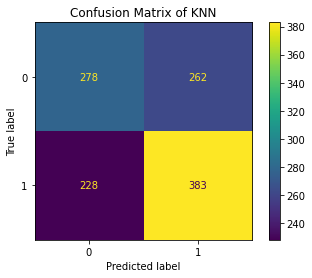

In [6]:
from sklearn.neighbors import KNeighborsClassifier

bestNvals = []
allScores = []
nMatrices = []
for modelDataIdx, holdoutDataIdx in holdoutSet.split(rawX, rawY):
    knnScores = []

    # Hyperparameter tuning for logisitic regression:
    neighborsVector = [*range(10, 510, 20)]
    # This data is for developing the model:
    modelX, modelY = rawX[modelDataIdx], rawY[modelDataIdx]
    # This data is for evaluating the hyperparameter tuned model:
    holdoutX, holdoutY = rawX[holdoutDataIdx], rawY[holdoutDataIdx]

    # Now loop through all Cs after splitting into model and holdout data:
    for nValue in neighborsVector:
        nScore = []

        # Second k-fold CV loop:
        knnKFold = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 125156)
        for train_idx, test_idx in  knnKFold.split(modelX, modelY):
            # sklearn cannot converge without scaling data 
            # (gradient descent/convergence issues):
            trainingDataX, testDataX = scaler.fit_transform(modelX[train_idx]), scaler.fit_transform(modelX[test_idx])  
            trainingDataY, testDataY = modelY[train_idx], modelY[test_idx]

            # Logistic regression:
            knnModel = KNeighborsClassifier(n_neighbors = nValue, n_jobs = 3)
            knnModel.fit(trainingDataX, trainingDataY)
    
            # The accuracy_score function computes the accuracy, 
            # either the fraction (default) or the count (normalize=False) 
            # of correct predictions.
            nScore.append(knnModel.score(testDataX, testDataY))

        # The end of the CV loop will give you a score at each fold:
        knnScores.append(nScore)

    # Once you've gone through all the n-values, average the scores, find the best n-value:
    knnScores = np.asarray(knnScores)
    knnScores = np.average(knnScores, axis = 1)
    optimalN = np.argmax(knnScores)
    bestNvals.append(neighborsVector[optimalN])
    opt = 'Highest Accuracy @ N = ' + str(np.format_float_positional(neighborsVector[optimalN]))    

    # Now evaluate model on the holdout set with the optimal value for n:
    knnModel = KNeighborsClassifier(n_neighbors = neighborsVector[optimalN], n_jobs = 3)
    knnModel.fit(modelX, modelY)
    predictions = knnModel.predict(holdoutX)
    allScores.append(knnModel.score(holdoutX, holdoutY))

    # Plot score vs n value:
    plt.figure()
    plt.scatter(neighborsVector, knnScores)
    plt.scatter(neighborsVector[optimalN], knnScores[optimalN], c = 'r', label = opt)
    plt.xlabel('N value')
    plt.ylabel('Score (accuracy)')
    plt.title('Hyperparameter Tuning for KNN')
    plt.legend()
    plt.show()

    # Confusion matrix:
    nMatrices.append(confusion_matrix(holdoutY, predictions))

# Output of knn model:
print('The average accuracy of the knn model across all folds is:',
      "%.4f"%np.average(allScores))

# Output of knn model:
print('The average optimal value for n_neighbors across all folds is:',
      "%.4f"%np.average(bestNvals))

# Confusion matrix:
nMatrices = np.asarray(nMatrices)
nResults = np.sum(nMatrices, axis = 0)
dispKNN = ConfusionMatrixDisplay(nResults)
dispKNN.plot()
plt.title('Confusion Matrix of KNN')
plt.show()

## Combined Voting Classifier

Finally, develop a model that combines all of the previously used classifiers.

The average accuracy of the ensemble model across all folds is: 0.6116


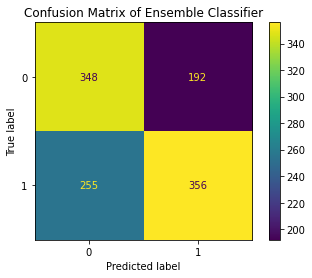

In [7]:
from sklearn.ensemble import VotingClassifier
import math

clf1 = LogisticRegression(C = np.average(bestCvals), max_iter = 500)
clf2 = svm.SVC(kernel = 'rbf', C = optParam, gamma = np.average(bestGvals), cache_size = 1000)
clf3 = KNeighborsClassifier(n_neighbors = math.floor(np.average(bestNvals)))

estimators = [('lr', clf1), ('knn', clf2), ('svm', clf3)]

ensembleScores = []
enMatrices = []
knnKFold = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 125156)
for train_idx, test_idx in  knnKFold.split(rawX, rawY):
    ensembleModel = VotingClassifier(estimators = estimators, n_jobs = -1)
    ensembleModel.fit(rawX[train_idx], rawY[train_idx])
    ensembleScores.append(ensembleModel.score(rawX[test_idx], rawY[test_idx]))
    predictions = ensembleModel.predict(rawX[test_idx])

    # Append to confusion matrix:
    enMatrices.append(confusion_matrix(rawY[test_idx], predictions))

# Output of ensemble model:
print('The average accuracy of the ensemble model across all folds is:',
      "%.4f"%np.average(ensembleScores))
      
# Confusion matrix:
enMatrices = np.asarray(enMatrices)
enResults = np.sum(enMatrices, axis = 0)
dispEN = ConfusionMatrixDisplay(enResults)
dispEN.plot()
plt.title('Confusion Matrix of Ensemble Classifier')
plt.show()
